In [326]:
import os

# Local network environment settings - if needed
# Used to download pretrained BERT
# os.environ["http_proxy"] = "127.0.0.1:11233"
# os.environ["https_proxy"] = "127.0.0.1:11233"

In [327]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")

In [328]:
import pytorch_pretrained_bert

In [329]:
import json
import gc

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear, SCHEDULES
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

In [330]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [331]:
import random
import numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

## Data Preparation

In [332]:
""" Load Data
    
    Outputs
    ----------
    df_data : pandas dataframe containing data

"""

df_data = pd.read_csv('EDU_pairs_TRAINING.csv')
df_data.head()

,File,Document,Sentence,EDU1,EDU2
0,wsj_0669,0,0,Nissan Motor Co. expects net income to reach 1...,U.S. $857 million
1,wsj_0669,0,0,U.S. $857 million,"in its current fiscal year, up from 114.6 bill..."
2,wsj_0669,0,0,"in its current fiscal year, up from 114.6 bill...","Yutaka Kume, president, said."
3,wsj_0669,0,1,Mr. Kume made the earnings projection for fisc...,"ending next March 31,"
4,wsj_0669,0,1,"ending next March 31,",in an interview with U.S. automotive writers


In [333]:
df_data.shape[0]

12083

In [334]:
df_data.EDU1.str.len().describe()

count    12083.000000
mean        42.825540
std         29.073975
min          2.000000
25%         21.000000
50%         36.000000
75%         58.000000
max        309.000000
Name: EDU1, dtype: float64

In [335]:
df_data.EDU2.str.len().describe()

count    12083.000000
mean        44.961930
std         29.097944
min          2.000000
25%         24.000000
50%         39.000000
75%         60.000000
max        309.000000
Name: EDU2, dtype: float64

#### Check how many edu's are really short

In [336]:
edu1_ix = df_data.index[df_data.EDU1.str.len() < 20]
edu2_ix = df_data.index[df_data.EDU2.str.len() < 20]


In [337]:
len(edu1_ix)

2688

In [338]:
len(edu2_ix)

2152

In [339]:
a = np.concatenate((edu1_ix, edu2_ix), axis=0)
len(a)

4840

In [340]:
len(np.unique(a))

4346

In [341]:
 df_data[df_data.EDU2.str.len() < 20].shape[0]

2152

In [342]:
# EDU1_check_count = df_data[df_data.EDU1.str.len() < k].shape[0]

checks = [5, 10, 20]

for k in checks:
    EDU1_check_count = df_data[df_data.EDU1.str.len() < k].shape[0]
    EDU1_check_fraction = EDU1_check_count/df_data.shape[0]
    EDU1_format = [k, EDU1_check_count, round(EDU1_check_fraction, 2)]

    EDU2_check_count = df_data[df_data.EDU2.str.len() < k].shape[0]
    EDU2_check_fraction = EDU2_check_count/df_data.shape[0]
    EDU2_format = [k, EDU2_check_count, round(EDU2_check_fraction, 2)]
    
    edu1_ix = df_data.index[df_data.EDU1.str.len() < k]
    edu2_ix = df_data.index[df_data.EDU2.str.len() < k]
    all_index = np.concatenate((edu1_ix, edu2_ix), axis=0)
    unique_rows = len(np.unique(all_index))
    unique_rows_fr = unique_rows/df_data.shape[0]
    rows_format = [k, unique_rows, round(unique_rows_fr, 2)]



    print ("EDU1 (length < {}): {} ({})".format(*EDU1_format))
    print ("EDU2 (length < {}): {} ({})".format(*EDU2_format))
    print ("Total Rows (length < {}): {} ({})".format(*rows_format))
    print("")

EDU1 (length < 5): 189 (0.02)
EDU2 (length < 5): 151 (0.01)
Total Rows (length < 5): 339 (0.03)

EDU1 (length < 10): 839 (0.07)
EDU2 (length < 10): 684 (0.06)
Total Rows (length < 10): 1468 (0.12)

EDU1 (length < 20): 2688 (0.22)
EDU2 (length < 20): 2152 (0.18)
Total Rows (length < 20): 4346 (0.36)



In [31]:
print(df_data.shape[0], df_data[df_data.EDU1.str.len() >= 20].shape[0], 
      df_data[df_data.EDU2.str.len() >= 20].shape[0],)

12083 9395 9931


#### Impose restrictions on length:

In [149]:
k = 10

In [150]:
df_full = df_data[df_data.EDU1.str.len() >= k].copy()
df_full.shape

(11244, 5)

In [151]:
df_full = df_full[df_full.EDU2.str.len() >= k].copy()
df_full.shape

(10615, 5)

In [32]:
# No Restrictions:

df_full = df_data.copy()
df_full.shape

(12083, 5)

## Model

In [343]:
final_res = np.load('NextEDU/nextedu_results.npy')
final_logit = np.load('NextEDU/nextedu_logits.npy')

In [344]:
print(len(final_res))
print(len(final_logit))

12083
12083


In [345]:
final_res

array([0.9999802 , 0.99995315, 0.99997365, ..., 0.9984876 , 0.99474853,
       0.05043332], dtype=float32)

In [346]:
final_logit

array([[ 5.6953754 , -5.135018  ],
       [ 5.40756   , -4.5601993 ],
       [ 5.552351  , -4.993738  ],
       ...,
       [ 3.9510546 , -2.5415049 ],
       [ 3.3196354 , -1.9243561 ],
       [-0.61386514,  2.3214886 ]], dtype=float32)

In [347]:
plt.rcParams["font.family"] = "SF Pro Display"

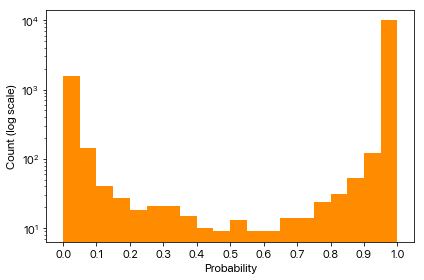

In [349]:
import matplotlib.pyplot as plt
import numpy as np
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# fig = plt.figure(figsize=[5, 5])
plt.hist(final_res, bins=20, color='darkorange')
plt.xticks(np.arange(0,1.1,0.1))
plt.tick_params(labelsize = 11)
plt.ylabel('Count (log scale)', fontsize=12)
plt.xlabel('Probability', fontsize=12)
plt.yscale('log', nonposy='clip')
plt.tight_layout()
plt.savefig('NextEDU/Probability_spread_orange_logscale.jpg', dpi = 300)
plt.show()



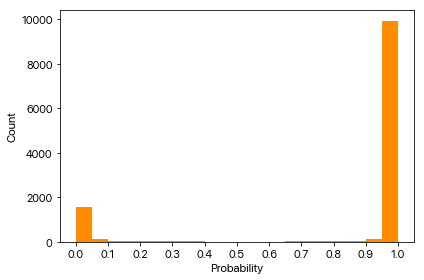

In [350]:
import matplotlib.pyplot as plt
import numpy as np
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# fig = plt.figure(figsize=[5, 5])
plt.hist(final_res, bins=20, color='darkorange')
plt.xticks(np.arange(0,1.1,0.1))
plt.tick_params(labelsize = 11)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Probability', fontsize=12)
plt.tight_layout()
# plt.savefig('NextEDU/Probability_spread_orange.jpg', dpi = 300)



In [352]:
groups = np.arange(0,1.1,0.1)

In [353]:
for interval in groups:
    print(interval, interval+0.1)
    print(sum((final_res > interval) & (final_res < interval+0.1)))
    print(" ")

0.0 0.1
1707
 
0.1 0.2
67
 
0.2 0.30000000000000004
39
 
0.30000000000000004 0.4
36
 
0.4 0.5
19
 
0.5 0.6
22
 
0.6000000000000001 0.7000000000000001
23
 
0.7000000000000001 0.8
38
 
0.8 0.9
84
 
0.9 1.0
10048
 
1.0 1.1
0
 


#### Calculate Accuracy

In [354]:
from sklearn.metrics import accuracy_score

In [355]:
y_true = np.ones(12083)

In [356]:
len(y_true)

12083

In [357]:
y_pred = []
for i in final_res:
    if i > 0.5:
        y_pred.append(1)
    elif i < 0.5:
        y_pred.append(0)

len(y_pred)

12083

In [358]:
accuracy_score(y_true, y_pred)

0.8454026317967392

In [359]:
## Lets calculate within document accuracy:
df_full.head()

,File,Document,Sentence,EDU1,EDU2
0,wsj_0669,0,0,Nissan Motor Co. expects net income to reach 1...,U.S. $857 million
1,wsj_0669,0,0,U.S. $857 million,"in its current fiscal year, up from 114.6 bill..."
2,wsj_0669,0,0,"in its current fiscal year, up from 114.6 bill...","Yutaka Kume, president, said."
3,wsj_0669,0,1,Mr. Kume made the earnings projection for fisc...,"ending next March 31,"
4,wsj_0669,0,1,"ending next March 31,",in an interview with U.S. automotive writers


In [360]:
# df_full.File.unique()
df_results = df_full.assign(Prediction=pd.Series(y_pred).values)

In [361]:
df_results.head()

,File,Document,Sentence,EDU1,EDU2,Prediction
0,wsj_0669,0,0,Nissan Motor Co. expects net income to reach 1...,U.S. $857 million,1
1,wsj_0669,0,0,U.S. $857 million,"in its current fiscal year, up from 114.6 bill...",1
2,wsj_0669,0,0,"in its current fiscal year, up from 114.6 bill...","Yutaka Kume, president, said.",1
3,wsj_0669,0,1,Mr. Kume made the earnings projection for fisc...,"ending next March 31,",1
4,wsj_0669,0,1,"ending next March 31,",in an interview with U.S. automotive writers,1


In [362]:
df_predictions = df_results[['File','Prediction']]

In [363]:
df_predictions.head()

,File,Prediction
0,wsj_0669,1
1,wsj_0669,1
2,wsj_0669,1
3,wsj_0669,1
4,wsj_0669,1


In [364]:
df_predictions

,File,Prediction
0,wsj_0669,1
1,wsj_0669,1
2,wsj_0669,1
3,wsj_0669,1
4,wsj_0669,1
5,wsj_0669,1
6,wsj_0669,1
7,wsj_0669,1
8,wsj_0669,1
9,wsj_0669,0


In [64]:
df_predictions.to_csv("NextEDU/Test_Predictions.csv")

In [365]:
# g = df_results.groupby(["File"])
# print(g.groups)

df_accuracy_by_doc = df_predictions.groupby(['File']).mean()
df_accuracy_by_doc.head()

,Prediction
File,
fil,0.911111
file2,0.885714
file3,0.833333
file4,0.961538
file5,0.858209


In [65]:
df_accuracy_by_doc.to_csv("Accuracy_per_doc.csv")

In [366]:
df_accuracy_by_doc.Prediction.mean()

0.8514519733028277

In [367]:
filenames = list(df_accuracy_by_doc.index)

In [368]:
accuracy_score = list(df_accuracy_by_doc.Prediction)

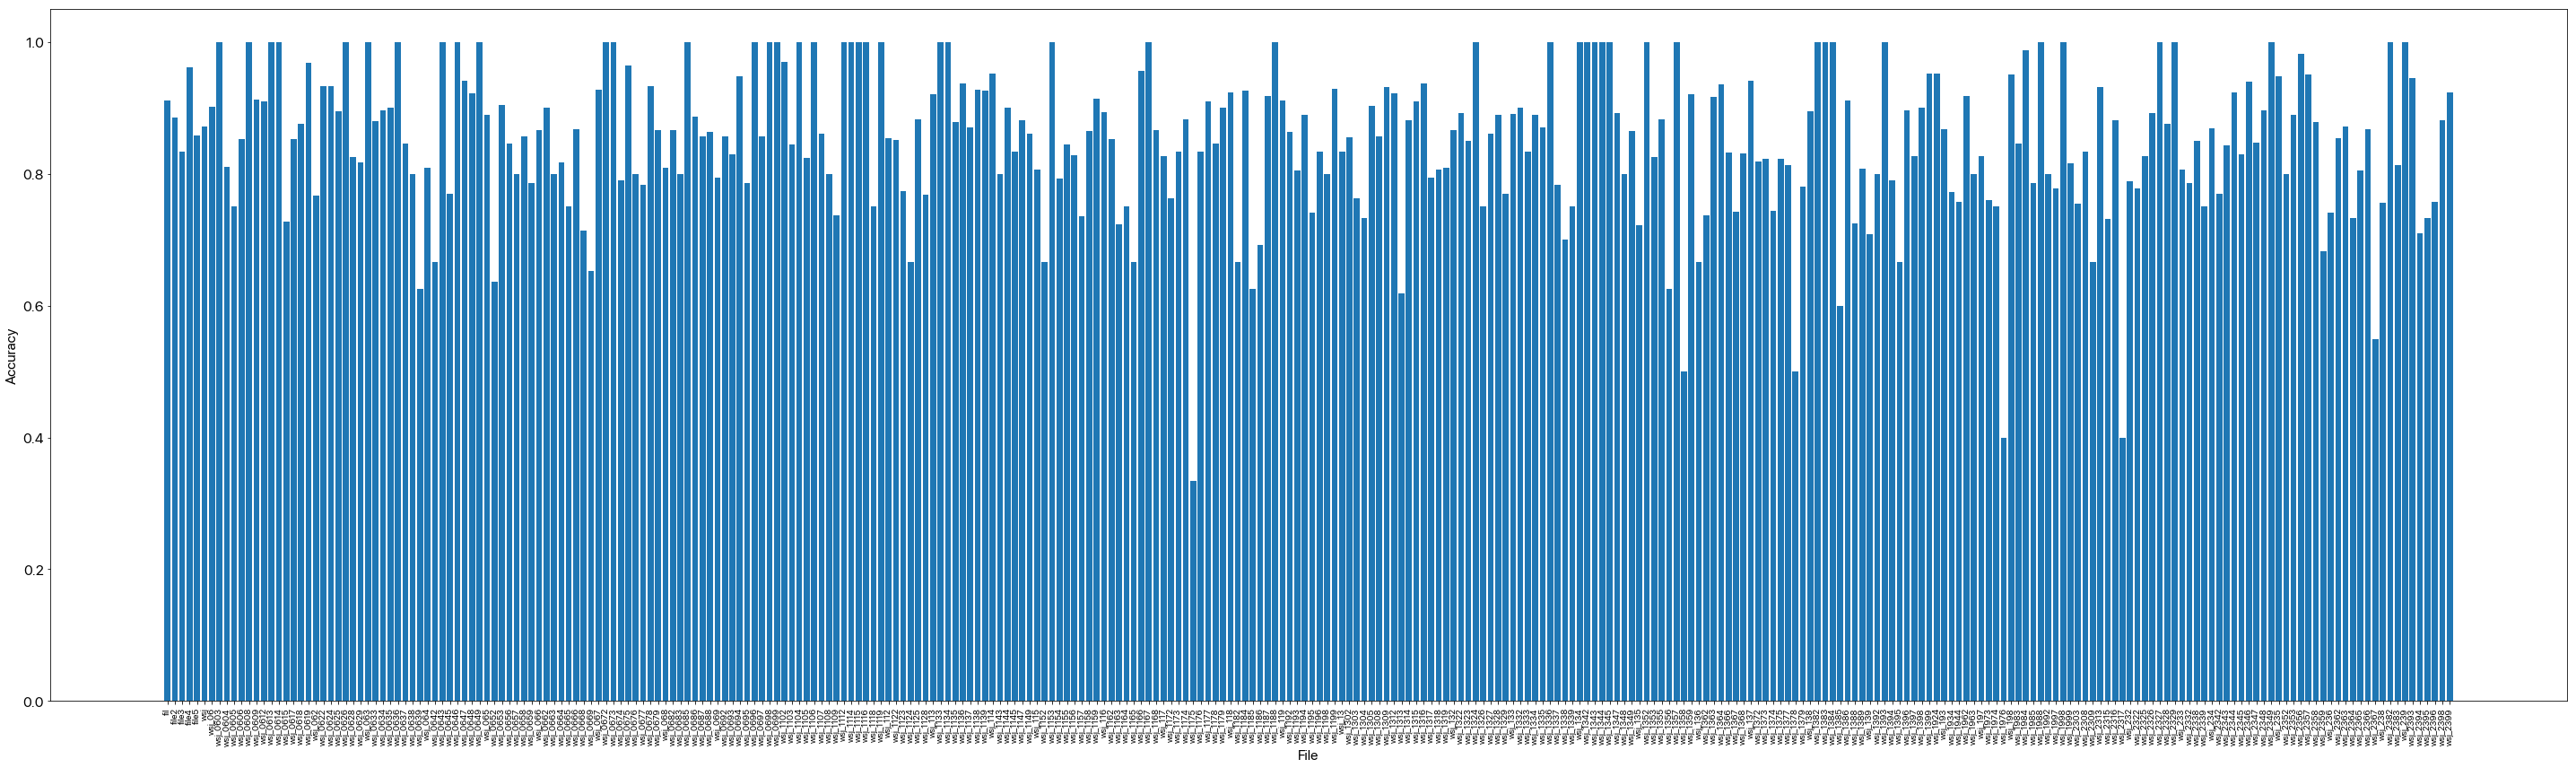

In [369]:
import matplotlib.pyplot as plt
import numpy as np
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
fig = plt.figure(figsize=[40, 12])
plt.bar(filenames, accuracy_score)

# plt.hist(final_res, bins=50, color='darkorange')
# plt.xticks(np.arange(0,1.1,0.1))
plt.tick_params(axis='x', labelsize = 10)
plt.tick_params(axis='y', labelsize = 16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('File', fontsize=16)
plt.xticks(rotation='vertical')
plt.tight_layout()
# plt.show()
# plt.savefig('NextEDU/Per_Doc_Accuracy_2.jpg', dpi = 300)



In [370]:
df_accuracy_by_doc.loc[df_accuracy_by_doc['Prediction'] < 0.5]

,Prediction
File,
wsj_1175,0.333333
wsj_1976,0.400000
wsj_2317,0.400000


### Let examine length vs. accuracy

In [135]:
df_lva = df_full.assign(Accuracy_score=pd.Series(final_res).values)
df_lva.head()

,File,Document,Sentence,EDU1,EDU2,Accuracy_score
0,wsj_0669,0,0,Nissan Motor Co. expects net income to reach 1...,U.S. $857 million,0.999980
1,wsj_0669,0,0,U.S. $857 million,"in its current fiscal year, up from 114.6 bill...",0.999953
2,wsj_0669,0,0,"in its current fiscal year, up from 114.6 bill...","Yutaka Kume, president, said.",0.999974
3,wsj_0669,0,1,Mr. Kume made the earnings projection for fisc...,"ending next March 31,",0.999970
4,wsj_0669,0,1,"ending next March 31,",in an interview with U.S. automotive writers,0.999815


In [136]:
df_lva = df_lva.assign(EDU1_Length=pd.Series(list(df_lva.EDU1.str.len())).values)
df_lva = df_lva.assign(EDU2_Length=pd.Series(list(df_lva.EDU2.str.len())).values)

In [137]:
df_lva.head()


,File,Document,Sentence,EDU1,EDU2,Accuracy_score,EDU1_Length,EDU2_Length
0,wsj_0669,0,0,Nissan Motor Co. expects net income to reach 1...,U.S. $857 million,0.999980,60,17
1,wsj_0669,0,0,U.S. $857 million,"in its current fiscal year, up from 114.6 bill...",0.999953,17,75
2,wsj_0669,0,0,"in its current fiscal year, up from 114.6 bill...","Yutaka Kume, president, said.",0.999974,75,29
3,wsj_0669,0,1,Mr. Kume made the earnings projection for fisc...,"ending next March 31,",0.999970,54,21
4,wsj_0669,0,1,"ending next March 31,",in an interview with U.S. automotive writers,0.999815,21,44


In [193]:
EDU1length_below05 = list(df_lva.EDU1_Length[df_lva.Accuracy_score < 0.5])
EDU2length_below05 = list(df_lva.EDU2_Length[df_lva.Accuracy_score < 0.5])
accscore_below05 = list(df_lva.Accuracy_score[df_lva.Accuracy_score < 0.5])

In [241]:
EDU1length_between0208 = list(df_lva.EDU1_Length[(df_lva.Accuracy_score < 0.8) & (df_lva.Accuracy_score > 0.2)])
EDU2length_between0208 = list(df_lva.EDU2_Length[(df_lva.Accuracy_score < 0.8) & (df_lva.Accuracy_score > 0.2)])
accscore_between0208 = list(df_lva.Accuracy_score[(df_lva.Accuracy_score < 0.8) & (df_lva.Accuracy_score > 0.2)])

In [178]:
EDU1length_above05 = list(df_lva.EDU1_Length[df_lva.Accuracy_score > 0.5])

In [179]:
EDU2length_above05 = list(df_lva.EDU2_Length[df_lva.Accuracy_score > 0.5])

In [181]:
accscore_above05 = list(df_lva.Accuracy_score[df_lva.Accuracy_score > 0.5])

In [138]:
accscore = list(df_lva.Accuracy_score)

In [141]:
EDU1length = list(df_lva.EDU1_Length)

In [147]:
EDU2length = list(df_lva.EDU2_Length)

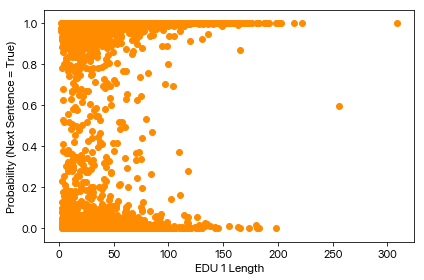

In [146]:

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# fig = plt.figure(figsize=[5, 5])
plt.scatter(EDU1length, accscore, color='darkorange')
# plt.xticks(np.arange(0,1.1,0.1))
plt.tick_params(labelsize = 11)
plt.ylabel('Probability (Next Sentence = True)', fontsize=12)
plt.xlabel('EDU 1 Length', fontsize=12)
plt.tight_layout()
# plt.savefig('NextEDU/

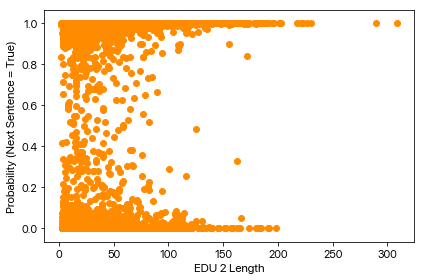

In [148]:
plt.scatter(EDU2length, accscore, color='darkorange')
# plt.xticks(np.arange(0,1.1,0.1))
plt.tick_params(labelsize = 11)
plt.ylabel('Probability (Next Sentence = True)', fontsize=12)
plt.xlabel('EDU 2 Length', fontsize=12)
plt.tight_layout()
# plt.savefig('NextEDU/

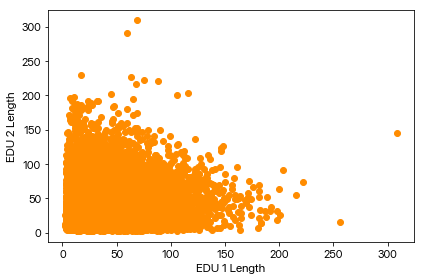

In [149]:
plt.scatter(EDU1length, EDU2length, color='darkorange')
# plt.xticks(np.arange(0,1.1,0.1))
plt.tick_params(labelsize = 11)
plt.ylabel('EDU 2 Length', fontsize=12)
plt.xlabel('EDU 1 Length', fontsize=12)
plt.tight_layout()

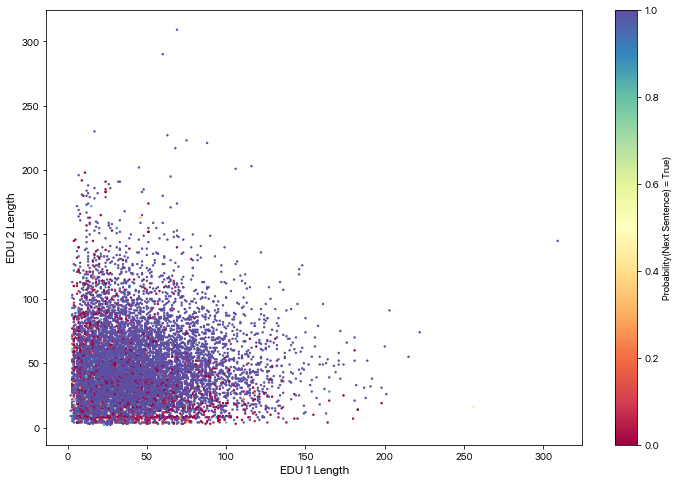

In [210]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[12, 8])
plt.scatter(EDU1length, EDU2length, c=accscore, s=2, cmap='Spectral')
plt.clim(0.0,1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability(Next Sentence) = True)')
plt.ylabel('EDU 2 Length', fontsize=12)
plt.xlabel('EDU 1 Length', fontsize=12)
plt.savefig('NextEDU/EDUsvsProbability_spectral.jpg', dpi = 300)
plt.show()

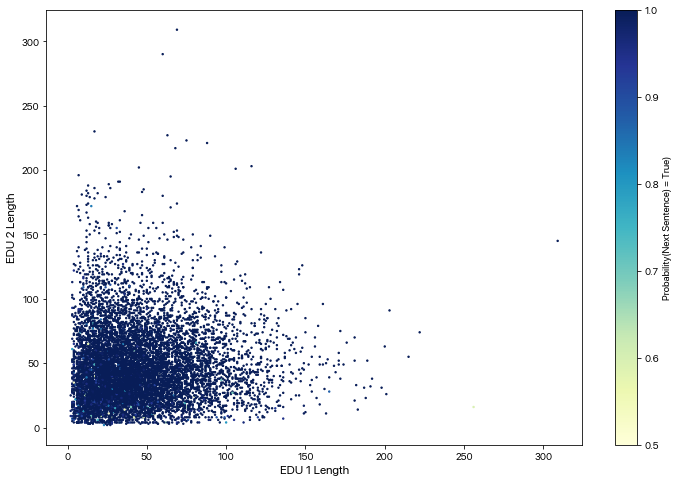

In [371]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[12, 8])
plt.scatter(EDU1length_above05, EDU2length_above05, c=accscore_above05, s=2, cmap='YlGnBu')

plt.clim(0.5,1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability(Next Sentence) = True)')
plt.ylabel('EDU 2 Length', fontsize=12)
plt.xlabel('EDU 1 Length', fontsize=12)


# plt.savefig('NextEDU/EDUsvsProbability_above05.jpg', dpi = 300)
plt.show()

In [205]:
min(accscore_below05)

3.4437796330166748e-06

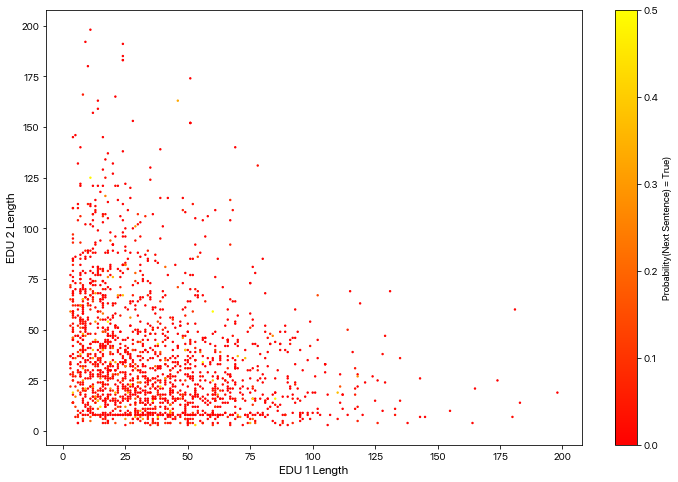

In [208]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[12, 8])
plt.scatter(EDU1length_below05, EDU2length_below05, c=accscore_below05, s=2, cmap='autumn')
plt.clim(0,0.5)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability(Next Sentence) = True)')
plt.ylabel('EDU 2 Length', fontsize=12)
plt.xlabel('EDU 1 Length', fontsize=12)


plt.savefig('NextEDU/EDUsvsProbability_below05.jpg', dpi = 300)
plt.show()

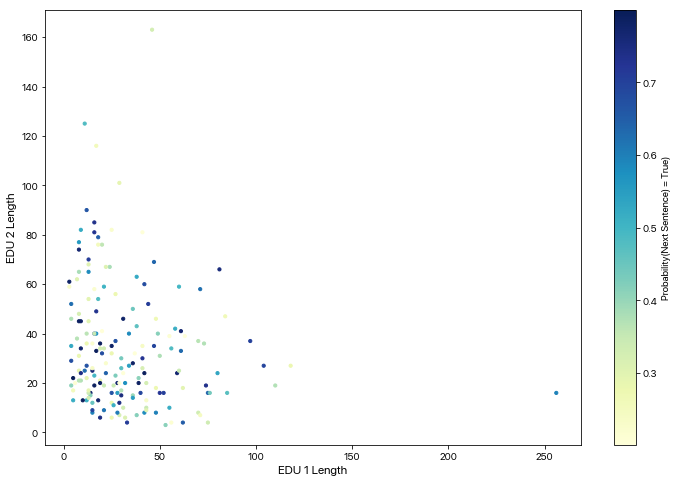

In [246]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[12, 8])
plt.scatter(EDU1length_between0208, EDU2length_between0208, c=accscore_between0208, s=10, cmap='YlGnBu')
# plt.clim(0,0.5)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Probability(Next Sentence) = True)')
plt.ylabel('EDU 2 Length', fontsize=12)
plt.xlabel('EDU 1 Length', fontsize=12)


# plt.savefig('NextEDU/EDUsvsProbability_below05.jpg', dpi = 300)
plt.show()

In [214]:
sum(final_res)/len(final_res)

0.8451174471337674

In [110]:
sum(final_res > 0.99) / len(final_res), sum(final_res > 0.9) / len(final_res), sum(final_res < 0.5) / len(final_res)

(0.7752213854175287, 0.8315815608706447, 0.15459736820326078)

### Lets see examples of wrong predictions

In [271]:
predicted_right = list(np.where(final_res > 0.5)[0])

In [230]:
predicted_wrong = list(np.where(final_res < 0.5)[0])

In [325]:
1868+10215

12083

In [232]:
predicted_wrong

[9,
 10,
 13,
 14,
 16,
 18,
 19,
 21,
 23,
 26,
 33,
 41,
 43,
 71,
 73,
 75,
 80,
 87,
 93,
 96,
 100,
 108,
 112,
 113,
 117,
 127,
 128,
 131,
 132,
 153,
 165,
 166,
 175,
 190,
 193,
 195,
 201,
 204,
 209,
 210,
 222,
 230,
 234,
 238,
 242,
 252,
 259,
 267,
 282,
 287,
 301,
 306,
 316,
 327,
 336,
 339,
 346,
 347,
 349,
 359,
 365,
 378,
 379,
 383,
 406,
 408,
 409,
 413,
 417,
 426,
 430,
 431,
 435,
 439,
 441,
 446,
 447,
 454,
 457,
 481,
 482,
 485,
 493,
 494,
 503,
 505,
 514,
 528,
 532,
 534,
 536,
 540,
 544,
 568,
 572,
 585,
 586,
 591,
 593,
 594,
 616,
 617,
 630,
 631,
 642,
 651,
 662,
 671,
 688,
 690,
 691,
 693,
 696,
 711,
 712,
 713,
 714,
 718,
 720,
 722,
 726,
 730,
 745,
 765,
 771,
 777,
 781,
 789,
 805,
 812,
 832,
 833,
 834,
 840,
 871,
 881,
 886,
 887,
 900,
 904,
 906,
 910,
 912,
 913,
 921,
 923,
 924,
 928,
 929,
 931,
 945,
 948,
 951,
 973,
 977,
 979,
 992,
 997,
 1008,
 1022,
 1025,
 1027,
 1039,
 1045,
 1046,
 1052,
 1068,
 1069,
 10

In [251]:

idx =5781
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

('The bank had been suffering in late 1987 from a slew of bad real estate loans',
 'made in Arizona.')

In [250]:
idx =6345
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

('She believes',
 "the impact of losses from these catastrophes isn't likely to halt the growth of the industry's surplus capital next year.")

In [249]:
idx = 5287
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

("we'll call Ben", 'works part-time as a consultant,')

In [248]:
idx = 4565
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

('it received an order for 23 of the vehicles,',
 'which retrieve tanks and other heavy-tracked vehicles')

In [212]:
idx = 10
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

('During the next decade,', 'Mr. Kume said,')

In [233]:
idx = 2281
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

('that', 'its fans claim')

In [247]:
idx = 3897
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

('The U.S. is submitting the proposal today in Geneva,', 'hoping')

In [256]:
print(sum(EDU1length_above05)/len(EDU1length_above05))
print(sum(EDU2length_above05)/len(EDU2length_above05))

43.74038179148312
46.16485560450318


In [257]:
print(sum(EDU1length_below05)/len(EDU1length_below05))
print(sum(EDU2length_below05)/len(EDU2length_below05))

37.82280513918629
38.3838329764454


In [268]:
said_counter_edu1 = 0
said_counter_edu2 = 0

for ix in predicted_wrong:
    if "said" in df_full.iloc[ix].EDU1:
        said_counter_edu1+=1
    if "said" in df_full.iloc[ix].EDU2:
        said_counter_edu2 +=1    

In [270]:
said_counter_edu1, said_counter_edu2

(261, 227)

In [276]:
said_counter_edu1/len(predicted_wrong), said_counter_edu2/len(predicted_wrong)

(0.13972162740899358, 0.1215203426124197)

In [274]:
said_counter_edu1_right = 0
said_counter_edu2_right = 0

for ix in predicted_right:
    if "said" in df_full.iloc[ix].EDU1:
        said_counter_edu1_right+=1
    if "said" in df_full.iloc[ix].EDU2:
        said_counter_edu2_right +=1    

In [290]:
said_counter_edu1_right, said_counter_edu2_right

(636, 341)

In [277]:
said_counter_edu1_right/len(predicted_right), said_counter_edu2_right/len(predicted_right)

(0.06226138032305433, 0.03338228095937347)

In [ ]:
idx = 2281
df_full.iloc[idx].EDU1, df_full.iloc[idx].EDU2

In [ ]:
from pprint import pprint
for _, row in df_full.iloc[best_matches].iterrows():
    pprint(row.to_dict())

### Can we find the most common tokens in predicted vs not-predicted? Is there a difference?

In [291]:
EDU1_right = []
EDU2_right = []

for ix in predicted_right:
    EDU1_right.append(df_full.iloc[ix].EDU1)
    EDU2_right.append(df_full.iloc[ix].EDU2)

In [294]:
EDU1_wrong = []
EDU2_wrong = []

for ix in predicted_wrong:
    EDU1_wrong.append(df_full.iloc[ix].EDU1)
    EDU2_wrong.append(df_full.iloc[ix].EDU2)

In [310]:
EDU1_right_text = ' '.join(EDU1_right).lower()
EDU2_right_text = ' '.join(EDU2_right).lower()


EDU1_wrong_text = ' '.join(EDU1_wrong).lower()
EDU2_wrong_text = ' '.join(EDU2_wrong).lower()

In [311]:
import spacy
from collections import Counter

In [315]:
nlp = spacy.load('en')
doc = nlp(EDU1_right_text)
# all tokens that arent stop words or punctuations

In [317]:
EDU1_right_text_lemma = ' '.join([token.lemma_ for token in doc])

In [319]:
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# noun tokens that arent stop words or punctuations
nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(20)

# five most common noun tokens
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(20)

In [320]:
common_words

[('said', 637),
 ('$', 515),
 ('million', 339),
 ('mr', 332),
 ('company', 283),
 ('new', 230),
 ('year', 226),
 ('u.s', 210),
 ('market', 191),
 ('corp', 187),
 ('inc', 168),
 ('billion', 158),
 ('co.', 149),
 ('stock', 145),
 ('says', 124),
 ('federal', 122),
 ('shares', 120),
 ('president', 114),
 ('sales', 108),
 ('bonds', 107)]

In [321]:
doc2 = nlp(EDU1_right_text_lemma)
words = [token.text for token in doc2 if token.is_stop != True and token.is_punct != True]

# noun tokens that arent stop words or punctuations
nouns = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(20)

# five most common noun tokens
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(20)

common_words

[('-PRON-', 2202),
 ('$', 515),
 ('company', 362),
 ('million', 342),
 ('mr', 332),
 ('year', 325),
 ('market', 236),
 ('new', 233),
 ('share', 219),
 ('u.s', 207),
 ('price', 205),
 ('stock', 197),
 ('corp', 187),
 ('inc', 168),
 ('billion', 161),
 ('bond', 151),
 ('co.', 149),
 ('sale', 139),
 ('expect', 130),
 ('buy', 128)]